In [1]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from scipy import stats
from scipy.stats import zscore
from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
zip_path = "ALLFLOWMETER_HIKARI2021.zip"

with zipfile.ZipFile(zip_path, 'r') as zipped_file:
    csv_file_name = zipped_file.namelist()[0]

    with zipped_file.open(csv_file_name) as csv_file:
        df = pd.read_csv(csv_file)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555278 entries, 0 to 555277
Data columns (total 88 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0.1              555278 non-null  int64  
 1   Unnamed: 0                555278 non-null  int64  
 2   uid                       555278 non-null  object 
 3   originh                   555278 non-null  object 
 4   originp                   555278 non-null  int64  
 5   responh                   555278 non-null  object 
 6   responp                   555278 non-null  int64  
 7   flow_duration             555278 non-null  float64
 8   fwd_pkts_tot              555278 non-null  int64  
 9   bwd_pkts_tot              555278 non-null  int64  
 10  fwd_data_pkts_tot         555278 non-null  int64  
 11  bwd_data_pkts_tot         555278 non-null  int64  
 12  fwd_pkts_per_sec          555278 non-null  float64
 13  bwd_pkts_per_sec          555278 non-null  f

In [30]:
df.head(100)

,Unnamed: 0.1,Unnamed: 0,uid,originh,originp,responh,responp,flow_duration,fwd_pkts_tot,bwd_pkts_tot,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category
0,0,0,Cg61Jch3vdz9DBptj,103.255.15.23,13316,128.199.242.104,443,2.207588,15,14,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML
1,1,1,CdRIlqLWdj35Y9vW9,103.255.15.23,13318,128.199.242.104,443,15.624266,15,14,...,158109.181742,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML
2,2,2,CLzp9Khd0Y09Qkgrg,103.255.15.23,13320,128.199.242.104,443,12.203357,14,13,...,125449.251656,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML
3,3,3,Cnf1YA4iLB4CSNWB88,103.255.15.23,13322,128.199.242.104,443,9.992448,14,13,...,123182.931318,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML
4,4,4,C4ZKvv3fpO72EAOsJ6,103.255.15.23,13324,128.199.242.104,443,7.780611,14,14,...,126016.885411,7.545305e+06,7.545305e+06,7.545305e+06,7.545305e+06,0.0,29200,65160,0,Bruteforce-XML
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,95,CclmWu1Md6NZCAGwu9,103.255.15.23,13524,128.199.242.104,443,20.614954,15,14,...,129106.417995,2.037188e+07,2.037188e+07,2.037188e+07,2.037188e+07,0.0,29200,65160,0,Bruteforce-XML
96,96,96,CCt8Y02LaZYIfq8EWe,103.255.15.23,13526,128.199.242.104,443,13.368241,14,13,...,121867.612469,1.313634e+07,1.313634e+07,1.313634e+07,1.313634e+07,0.0,29200,65160,0,Bruteforce-XML
97,97,97,CCXCut4ojxBpmAFEM2,103.255.15.23,13528,128.199.242.104,443,11.144496,14,14,...,135429.288208,1.089348e+07,1.089348e+07,1.089348e+07,1.089348e+07,0.0,29200,65160,0,Bruteforce-XML
98,98,98,C8xR1z4eFC6tGSTLu5,103.255.15.23,13530,128.199.242.104,443,8.897523,15,15,...,124421.037139,8.662633e+06,8.662633e+06,8.662633e+06,8.662633e+06,0.0,29200,65160,0,Bruteforce-XML


In [24]:
df = df.drop(labels='Label', axis=1)

### Traffic Category Distribution

In [25]:
df['traffic_category'].value_counts()

Benign                 347431
Background             170151
Probing                 23388
Bruteforce               5884
Bruteforce-XML           5145
XMRIGCC CryptoMiner      3279
Name: traffic_category, dtype: int64

In [26]:
df['traffic_category'].unique()

array(['Bruteforce-XML', 'Bruteforce', 'Background', 'Benign', 'Probing',
       'XMRIGCC CryptoMiner'], dtype=object)

C:\Users\mradi\AppData\Local\Temp\ipykernel_1968\1110420429.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='traffic_category', data=df, palette='viridis')


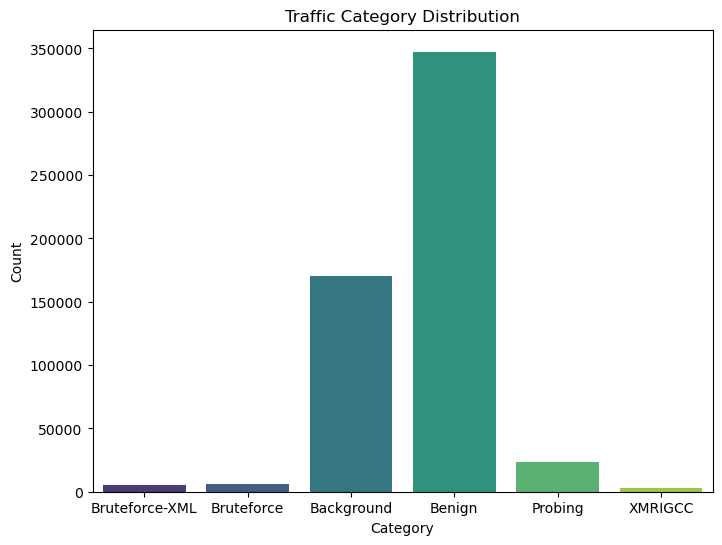

In [27]:
plt.figure(figsize=(8, 6))
sns.countplot(x='traffic_category', data=df, palette='viridis')
plt.title('Traffic Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5], labels=['Bruteforce-XML', 'Bruteforce', 'Background', 'Benign', 'Probing', 'XMRIGCC'])
plt.show()

### Features

In [28]:
numerical_features = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
categorical_features = df.select_dtypes(include=["object", "category"]).columns.tolist()

# Pisahkan target class
target = "traffic_category"
if target in numerical_features:
    numerical_features.remove(target)
elif target in categorical_features:
    categorical_features.remove(target)

In [29]:
for feature in categorical_features:
    unique_values = df[feature].nunique()
    print(f"Fitur '{feature}' memiliki {unique_values} nilai unik.")

Fitur 'uid' memiliki 555278 nilai unik.
Fitur 'originh' memiliki 2899 nilai unik.
Fitur 'responh' memiliki 7991 nilai unik.
